# Full pipeline
This notebook is made to explain to full pipeline of the language detection process. In the end we can see that the alt text was indeed updated to the generated text. In this example an SVM model was used based on the proccesing speed, this could be replaced by any of the other models.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vande\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vande\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Error processing C:\Users\vande\Downloads\epubs\fiction\The-Book-of-the-Thousand-Nights-and-a-Night-vol-2.epub: 'Bad Zip file'
Error processing C:\Users\vande\Downloads\epubs\non-fiction\A-Course-of-Pure-Mathematics.epub: 'Bad Zip file'
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        22
           1       0.84      0.80      0.82        20

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42

Confusion Matrix:
[[19  3]
 [ 4 16]]
Combined Accuracy: 83.33%


C:\Users\vande\anaconda3\Lib\site-packages\ebooklib\epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')


Classification: Fiction
Detected language: nl


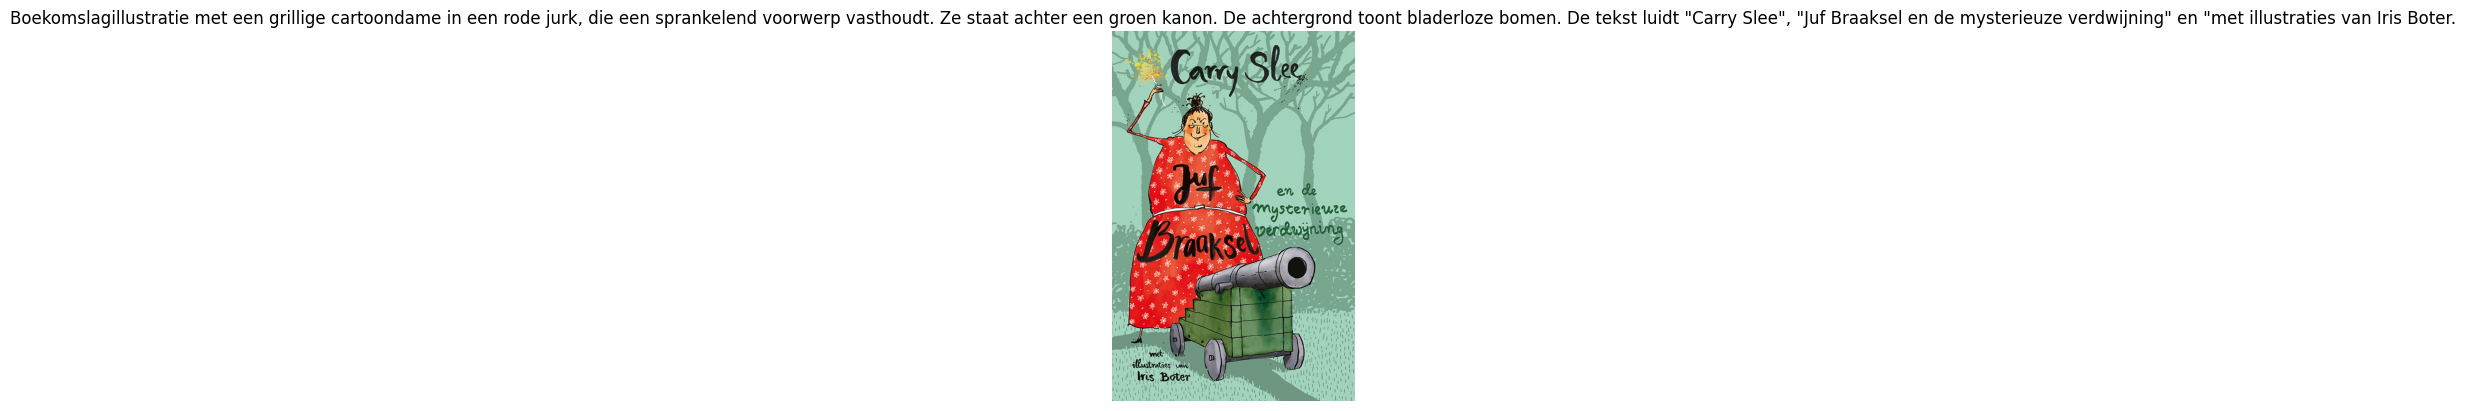

Updated alt text for image EPUB/images/cover.jpg
Image images/cover.jpg has alt text: Boekomslagillustratie met een grillige cartoondame in een rode jurk, die een sprankelend voorwerp vasthoudt. Ze staat achter een groen kanon. De achtergrond toont bladerloze bomen. De tekst luidt "Carry Slee", "Juf Braaksel en de mysterieuze verdwijning" en "met illustraties van Iris Boter.


In [56]:
import os
import zipfile
import xml.etree.ElementTree as ET
import requests
import base64
import pandas as pd
import nltk
from ebooklib import epub
from bs4 import BeautifulSoup
from langdetect import detect
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from PIL import Image
import io
import matplotlib.pyplot as plt

# Download nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize translator
translator = Translator()

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Function to translate text to English if necessary
def translate_to_english(text, src_lang):
    if src_lang != 'en':
        translated = translator.translate(text, src=src_lang, dest='en')
        return translated.text
    return text

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

# Function to extract text from an EPUB file
def extract_text_from_epub(file_path, max_words=1024):
    try:
        book = epub.read_epub(file_path)
        text = ''
        for item in book.get_items():
            if isinstance(item, epub.EpubHtml):
                soup = BeautifulSoup(item.content, 'html.parser')
                text += ' '.join(soup.stripped_strings) + ' '
        tokens = nltk.word_tokenize(text)
        truncated_text = ' '.join(tokens[:max_words])
        detected_language = detect_language(truncated_text)
        if detected_language:
            translated_text = translate_to_english(truncated_text, detected_language)
            cleaned_text = clean_text(translated_text)
            return cleaned_text if cleaned_text else None
        else:
            print(f"Could not detect language for {file_path}")
            return None
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load the data
def load_data(directory, label):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.epub'):
            file_path = os.path.join(directory, filename)
            text = extract_text_from_epub(file_path)
            if text:
                data.append((text, label))
    return data

# Train the model
def train_model(fiction_dir, non_fiction_dir):
    fiction_data = load_data(fiction_dir, 'Fiction')
    non_fiction_data = load_data(non_fiction_dir, 'Non-Fiction')

    df = pd.DataFrame(fiction_data + non_fiction_data, columns=['text', 'label'])
    df['label'] = df['label'].map({'Fiction': 0, 'Non-Fiction': 1})

    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

    stop_words = list(nltk.corpus.stopwords.words('english'))
    vectorizer = TfidfVectorizer(max_features=30000, stop_words=stop_words, ngram_range=(1, 3))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model = SVC()
    param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train_vec, y_train)

    y_pred = grid_search.predict(X_test_vec)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    combined_accuracy = accuracy_score(y_test, y_pred)
    print(f"Combined Accuracy: {combined_accuracy:.2%}")

    return grid_search, vectorizer

# Function to classify an EPUB
def classify_epub(file_path, model, vectorizer):
    text = extract_text_from_epub(file_path)
    if text:
        text_vec = vectorizer.transform([text])
        prediction = model.predict(text_vec)[0]
        return 'Fiction' if prediction == 0 else 'Non-Fiction'
    return None

# Extract the language tag from an EPUB file
def get_language_from_epub(epub_file_path):
    with zipfile.ZipFile(epub_file_path, 'r') as epub:
        for file in epub.namelist():
            if 'content.opf' in file:
                with epub.open(file) as opf_file:
                    tree = ET.parse(opf_file)
                    root = tree.getroot()
                    for meta in root.findall('.//{http://purl.org/dc/elements/1.1/}language'):
                        return meta.text
    return 'en'

# Extract images from an EPUB file
def extract_images_from_epub(epub_file_path):
    images = []
    with zipfile.ZipFile(epub_file_path, 'r') as epub:
        for file in epub.namelist():
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                with epub.open(file) as image_file:
                    image_data = image_file.read()
                    images.append((file, image_data))
    return images

# Generate alt text using AltText.ai
def add_image_by_file_and_get_alt_text(image_data, model_name, lang, api_key):
    base64_image = base64.b64encode(image_data).decode('utf-8')
    
    payload = {
        'image': {
            'raw': base64_image
        },
        'model_name': model_name,
        'lang': lang
    }
    headers = {
        'X-API-Key': api_key,
        'Content-Type': 'application/json'
    }
    response = requests.post('https://alttext.ai/api/v1/images', json=payload, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        return data.get('alt_text', 'No alt text generated')
    else:
        print(f"Failed to fetch alt text using model {model_name}: {response.status_code} - {response.text}")
        return None

# Update the EPUB with the new alt text
def update_epub_with_alt_text(epub_file_path, target_image_name, new_alt_text):
    try:
        book = epub.read_epub(epub_file_path)
        for item in book.get_items():
            if isinstance(item, epub.EpubHtml):
                soup = BeautifulSoup(item.content, 'html.parser')
                images = soup.find_all('img')
                updated = False
                for img in images:
                    if 'src' in img.attrs and os.path.basename(target_image_name) in img['src']:
                        img['alt'] = new_alt_text
                        updated = True
                        break
                if updated:
                    item.content = str(soup).encode('utf-8')
        epub.write_epub(epub_file_path, book)
        print(f"Updated alt text for image {target_image_name}")
    except Exception as e:
        print(f"Error updating {epub_file_path}: {e}")

# Display the image along with its alt text
def display_image_with_alt_text(image_data, alt_text):
    image = Image.open(io.BytesIO(image_data))
    plt.imshow(image)
    plt.axis('off')
    plt.title(alt_text)
    plt.show()

# Main function to process the book
def process_book(epub_file_path, api_key, model, vectorizer):
    # Classify the book
    classification = classify_epub(epub_file_path, model, vectorizer)
    print(f"Classification: {classification}")

    # Extract language tag
    language = get_language_from_epub(epub_file_path)
    print(f"Detected language: {language}")

    # Extract images
    images = extract_images_from_epub(epub_file_path)
    if images:
        first_image_name, first_image_data = images[0]
        model_name = "describe-factual" if classification == "Non-Fiction" else "describe-detailed"
        alt_text = add_image_by_file_and_get_alt_text(first_image_data, model_name, language, api_key)
        if alt_text:
            display_image_with_alt_text(first_image_data, alt_text)
            return first_image_name, alt_text
        else:
            print("Failed to generate alt text.")
            return None, None
    else:
        print("No images found in the EPUB file.")
        return None, None

# Check if alt text is present for a specific image
def check_specific_image_alt_text(epub_file_path, target_image_name):
    try:
        book = epub.read_epub(epub_file_path)
        for item in book.get_items():
            if isinstance(item, epub.EpubHtml):
                soup = BeautifulSoup(item.content, 'html.parser')
                images = soup.find_all('img')
                for img in images:
                    if 'src' in img.attrs and os.path.basename(target_image_name) in img['src']:
                        if 'alt' in img.attrs and img.attrs['alt'].strip():
                            print(f"Image {img['src']} has alt text: {img['alt']}")
                        else:
                            print(f"Image {img['src']} does not have alt text.")
                        return
        print(f"Image {target_image_name} not found in {epub_file_path}.")
    except Exception as e:
        print(f"Error processing {epub_file_path}: {e}")

# Paths to directories
fiction_dir = r'C:\Users\vande\Downloads\epubs\fiction'
non_fiction_dir = r'C:\Users\vande\Downloads\epubs\non-fiction'

# Train the model
model, vectorizer = train_model(fiction_dir, non_fiction_dir)

# Process the book and get the first image name and its generated alt text
epub_file_path = r'C:\Users\vande\Downloads\epubs\Carry Slee - Juf Braaksel en de mysterieuze verdwijning-Overamstel.epub'
api_key = 'e5b19558ff44bdf034c5f2ba8dc785ac'
first_image_name, new_alt_text = process_book(epub_file_path, api_key, model, vectorizer)

# Update the EPUB with the new alt text for the first image
if first_image_name and new_alt_text:
    update_epub_with_alt_text(epub_file_path, first_image_name, new_alt_text)
    check_specific_image_alt_text(epub_file_path, first_image_name)
else:
    print("No image was processed for alt text generation or no alt text was generated.")
